In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [11]:
# --- Grad-CAM Function ---
def generate_gradcam(img_path, model, last_conv_layer_name="block_16_project_BN"):
    """
    Generates a Grad-CAM heatmap superimposed on the input image.
    
    Parameters:
    - img_path: str, path to input image
    - model: trained Keras model
    - last_conv_layer_name: str, name of the last convolutional layer for Grad-CAM

    Returns:
    - superimposed_img: numpy array of RGB image with heatmap overlay
    """

    # load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalize input for MobileNetV2
    
    # create a model that maps input to (conv layer output, prediction)
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # use GradientTape to compute gradients of the target class prediction w.r.t. conv layer output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        target_class = predictions[:, 0]  # Class index 0: cataract (your case)

    # gradient of the target class score w.r.t. feature map
    grads = tape.gradient(target_class, conv_outputs)
    
    # take mean over height & width axes → gives importance weight for each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each feature map by its importance (channel-wise attention)
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU and Normalize
    heatmap = np.maximum(heatmap.numpy(), 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    
    # inverse heatmap because model predicts cataract (0) as positive class
    heatmap = 1.0 - heatmap

    # resize heatmap to match original image
    heatmap = cv2.resize(heatmap, (128, 128))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # load original image in OpenCV format (BGR), convert to RGB
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, (128, 128))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # blend the original image with heatmap
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

    return superimposed_img


In [12]:
model_path = "../best_model.h5"
model = load_model(model_path)

# display layer names to find the last conv layer
# for layer in model.layers:
#     print(layer.name)

c:\Users\hiron\miniconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


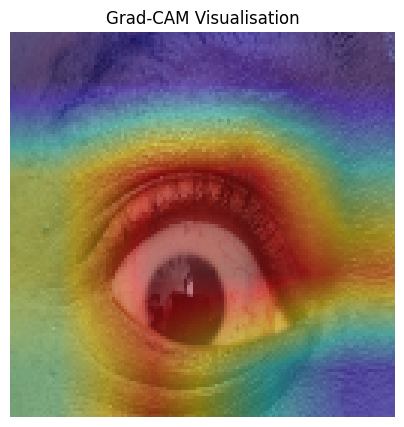

In [13]:
# predict & visualize Grad-CAM for a test image
img_path = "../data/self_test_data/r_eye_osee.jpg"
output_img = generate_gradcam(img_path, model)

plt.figure(figsize=(5, 5))
plt.imshow(output_img)
plt.axis("off")
plt.title("Grad-CAM Visualisation")
plt.show()
